# Analysis of loans with SQL and Python using SQLalchemy

In [1]:
import numpy as np
import pandas as pd
import sqlite3
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
%matplotlib inline

In [5]:
# Establish DB connection
conn = sqlite3.connect('data_banking.db')

In [6]:
c = conn.cursor()
qry = '''
DELETE FROM loan_book WHERE member_id = (SELECT member_id FROM loan_book LIMIT 15000 )
'''
c.execute(qry)
conn.commit()
conn.execute('VACUUM')
conn.commit()

In [7]:
conn.execute('VACUUM')

In [5]:
sqlite_query = """
SELECT COUNT(*) 
from loan_book 
"""

pd.read_sql(sqlite_query, conn)

,COUNT(*)
0,83475


In [11]:
sqlite_query = """
SELECT * 
from loan_book 
limit 5
"""

pd.read_sql(sqlite_query, conn)

,market,Amount,Term_nMonths,Annual_interest_rate,Date_of_disbursal,Date_of_default,Declared_income,loan_id,member_id
0,B,10000.0,60,0.0997,2016-04-04 09:20:04.903000,None,66318.0,6291910946835746176,5952682155246103118
1,A1,7500.0,48,0.0302,2016-04-06 12:00:43.360000,None,36000.0,-2243521942468637182,-3855500498482240246
2,A2,15000.0,60,0.0790,2016-04-05 11:12:03.257000,None,35000.0,4840418347660553669,-231649900945987447
3,A2,10000.0,48,0.0647,2016-10-31 11:04:04.047000,None,37626.0,-4920937880632372839,4359975814604347782
4,C1,5000.0,36,0.0946,2016-11-01 16:38:58.930000,None,23460.0,2518499440406368095,6191889373978101367


In [6]:
sqlite_query = """
SELECT * 
from loan_book 
limit 5
""" 

pd.read_sql(sqlite_query, conn)

,market,Amount,Term_nMonths,Annual_interest_rate,Date_of_disbursal,Date_of_default,Declared_income,loan_id,member_id
0,E,1000.0,60,0.2851,2016-11-29 10:34:05.923000,None,13000.0,-3293369904385415516,6884892257528709881
1,B,6000.0,48,0.0979,2016-11-24 21:33:59.753000,None,16999.0,1192553339230098173,5914817475616091627
2,A*,6000.0,36,0.0630,2016-11-25 01:02:56.413000,None,30000.0,6497637899299589044,7448522445922514136
3,A2,4000.0,36,0.0516,2016-11-30 12:10:30.520000,None,19000.0,6245920494459186679,-7383511048029073716
4,A2,5000.0,60,0.0301,2016-11-25 09:13:23.580000,None,12000.0,8669220502613782573,-191794435144291013


The second table "default_rate_estimate" contains a lookup table of the expected default rate for various type of loans:

In [7]:
sqlite_query = """
SELECT * 
from default_rate_estimate 
limit 5
"""

pd.read_sql(sqlite_query, conn)

,market,Term_nMonths,Annual_default_rate_estimate
0,A*,12,0.00344
1,A*,24,0.00345
2,A*,36,0.00303
3,A*,48,0.00356
4,A*,60,0.00446


## Check all the individual markets

In [8]:
sqlite_query = """
SELECT DISTINCT(MARKET) FROM loan_book
"""

pd.read_sql(sqlite_query, conn)

,market
0,E
1,B
2,A*
3,A2
4,A1
5,D
6,C1


## Number of loans in every market 

In [9]:
sqlite_query = """
SELECT market, count(loan_id) FROM loan_book GROUP BY market
"""

pd.read_sql(sqlite_query, conn)

,market,count(loan_id)
0,A*,18964
1,A1,11069
2,A2,11251
3,B,11879
4,C1,14133
5,D,9810
6,E,6369


## Top 3 months that have highest mean values of estimated annual default rate

In [10]:
sqlite_query = """
SELECT  avg(annual_default_rate_estimate) as 'Highest_Average_Values_of_Estimated_Annual_Default_Rate', strftime('%m',date_of_disbursal) as 'Months'
FROM loan_book
INNER JOIN
default_rate_estimate
ON loan_book.market = default_rate_estimate.market
group by strftime('%m',date_of_disbursal) 
order by avg(annual_default_rate_estimate) desc limit 3
"""

pd.read_sql(sqlite_query, conn)

,Highest_Average_Values_of_Estimated_Annual_Default_Rate,Months
0,0.058376,12
1,0.055656,11
2,0.052891,09


##  Mean of estimated annual default rate in every market? Comparison with the actual default rate within the first year from disbursal.



In [11]:
sqlite_query = """
SELECT AVG(annual_default_rate_estimate), market
FROM default_rate_estimate
group by market
"""

pd.read_sql(sqlite_query, conn)

,AVG(annual_default_rate_estimate),market
0,0.003588,A*
1,0.010130,A1
2,0.018248,A2
3,0.035702,B
4,0.064888,C1
5,0.134922,D
6,0.164392,E


## Borrowers that had more than one loans

In [12]:
sqlite_query = """
SELECT COUNT(*)AS 'Number of Borrowers who had Loans from Zopa More Than Once'
FROM (SELECT MEMBER_ID FROM LOAN_BOOK GROUP BY MEMBER_ID HAVING COUNT(*)>1)"""

pd.read_sql(sqlite_query, conn)

,Number of Borrowers who had Loans from Zopa More Than Once
0,2486


## Find repeat borrowers who got a new loan with a lower interest rate than their previous loan?

In [14]:
sqlite_query = """
select count(distinct member_id) 
from loan_book o1 
where exists (
    select member_id 
    from loan_book o2
    where o1.member_id = o2.member_id and 
          o1.date_of_disbursal > o2.date_of_disbursal and 
          o1.annual_interest_rate < o2.annual_interest_rate 
    );"""

pd.read_sql(sqlite_query, conn)

,count(distinct member_id)
0,858


In [15]:
df = pd.read_sql('SELECT * FROM loan_book', conn, parse_dates=['Date_of_disbursal', 'Date_of_default'])

## Add a new column to the dataframe that has the monthly payment for each loan


In [16]:
df = pd.read_sql('SELECT * FROM loan_book', conn, parse_dates=['Date_of_disbursal', 'Date_of_default'])
df["Monthly_Payment"]=(df["Annual_interest_rate"]/df["Term_nMonths"] *(df["Amount"]))+(df["Amount"]/df["Term_nMonths"])
df

,market,Amount,Term_nMonths,Annual_interest_rate,Date_of_disbursal,Date_of_default,Declared_income,loan_id,member_id,Monthly_Payment
0,E,1000.00,60,0.2851,2016-11-29 10:34:05.923,NaT,13000.0,-3293369904385415516,6884892257528709881,21.418333
1,B,6000.00,48,0.0979,2016-11-24 21:33:59.753,NaT,16999.0,1192553339230098173,5914817475616091627,137.237500
2,A*,6000.00,36,0.0630,2016-11-25 01:02:56.413,NaT,30000.0,6497637899299589044,7448522445922514136,177.166667
3,A2,4000.00,36,0.0516,2016-11-30 12:10:30.520,NaT,19000.0,6245920494459186679,-7383511048029073716,116.844444
4,A2,5000.00,60,0.0301,2016-11-25 09:13:23.580,NaT,12000.0,8669220502613782573,-191794435144291013,85.841667
5,E,1000.00,24,0.2539,2016-11-28 12:00:52.607,NaT,18000.0,-2123435157064978282,-2801251332176396972,52.245833
6,E,1200.00,60,0.2861,2016-11-28 09:24:17.260,NaT,19500.0,3446812887427267716,-4534826509667858637,25.722000
7,A2,6000.00,36,0.0304,2016-11-25 11:35:19.023,NaT,34680.0,-6076616271922616428,6256792048701530826,171.733333
8,B,5000.00,60,0.0956,2016-02-26 16:56:44.437,NaT,24000.0,1634640047718903421,-6921582440177485731,91.300000
9,B,5000.00,48,0.1010,2016-02-29 17:08:39.823,NaT,16000.0,-5765978219162588015,-3781289231690272537,114.687500


## Plot the number of loans going into default as a function of the number of days after the disbursal date


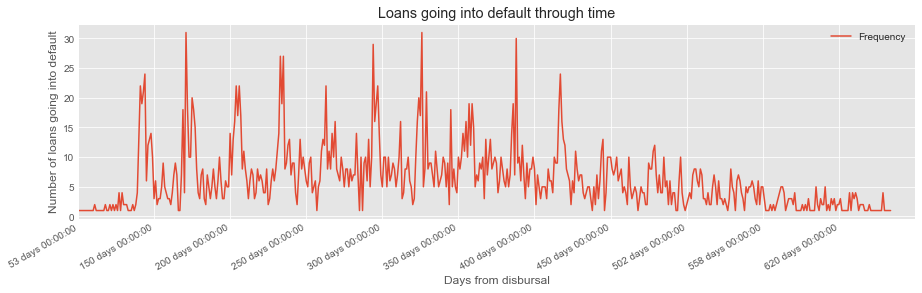

In [17]:
df["Monthly_Payment"]=(df["Annual_interest_rate"]/df["Term_nMonths"] *(df["Amount"]))+(df["Amount"]/df["Term_nMonths"])
df["Monthly_Payment"]
d=df.copy()
d.dropna(inplace=True)
d['Date_of_disbursal']= pd.to_datetime(d['Date_of_disbursal']).apply(lambda x: x.date())
d["Date_of_default"]=pd.to_datetime(df['Date_of_default']).apply(lambda x: x.date())
d["Gap_Between_Days"]=d["Date_of_default"]-d["Date_of_disbursal"]
d['freq'] = d.groupby(d['Gap_Between_Days'])['Term_nMonths'].transform('count')
dx=d[['Gap_Between_Days','freq']].copy()
dx.sort_values('Gap_Between_Days',ascending=1,inplace=True)
dx.drop_duplicates(inplace=True)
with plt.style.context('ggplot'):
    aw=dx.plot(title="Loans going into default through time",x=['Gap_Between_Days'],y=['freq'],figsize=(15,4),xticks=(np.arange( 0,600 ,50)))
aw.set_ylabel("Number of loans going into default")
aw.set_xlabel("Days from disbursal")
L=plt.legend()
L.get_texts()[0].set_text('Frequency')


## Declared income
### Find the average declared_income for loans disbursed in each month? 

In [28]:
print("**At this point where income is in question, it has to be some outlier detection and treatment if necessary**")
df1 = df[(df['Declared_income'] < 150000) & (df['Declared_income'] >=12000)] #being Zopa's minimum income qualified for loan.

avg_inc_per_month=round(df1.groupby(df['Date_of_disbursal'].dt.strftime('%B'))['Declared_income'].mean()).sort_values(ascending=False)
avg_inc_per_month.astype(int)

**At this point where income is in question, it has to be some outlier detection and treatment if necessary**


Date_of_disbursal
October      50193
January      34611
May          34438
June         34222
July         34194
August       34012
December     33754
September    33741
November     33639
February     33615
March        33499
April        33446
Name: Declared_income, dtype: int32

###  What are the statistical uncertainties of the average values computed above?  

Hint: We remind you that you are allowed to use Google to aid you

In [29]:
print("The fact that the mean was applied as a measure of central tendency in such a 'large' dataset was expected to cause statistical uncertainties since the mean is affected by the extreme values that are present in the 'Declared_income'column.")
avg_inc_per_month=round(df1.groupby(df['Date_of_disbursal'].dt.strftime('%B'))['Declared_income'].mean()).sort_values(ascending=False)
inc_std=round(df.groupby(df1['Date_of_disbursal'].dt.strftime('%B'))['Declared_income'].std()).sort_values(ascending=False)
inc_std.astype(int)
conc=pd.concat([avg_inc_per_month,inc_std], axis=1)
conc.columns=["mean","std"]
conc.sort_values('mean',ascending=False)

The fact that the mean was applied as a measure of central tendency in such a 'large' dataset was expected to cause statistical uncertainties since the mean is affected by the extreme values that are present in the 'Declared_income'column.


,mean,std
October,50193.0,31892.0
January,34611.0,19601.0
May,34438.0,18644.0
June,34222.0,18414.0
July,34194.0,17966.0
August,34012.0,18278.0
December,33754.0,19241.0
September,33741.0,18212.0
November,33639.0,18597.0
February,33615.0,18283.0


## Default rate
### For loans disbursed in each calendar month, how many of them have gone bad (defaulted)?

In [22]:
df.groupby(df['Date_of_disbursal'].dt.strftime('%B'))['Date_of_default'].count().sort_values(ascending=False)

Date_of_disbursal
January      460
February     383
August       354
June         331
May          302
April        285
March        265
July         260
September    221
October      201
November     183
December     182
Name: Date_of_default, dtype: int64

# Statistics 

Text(0.5,1,'Number of samples per market')

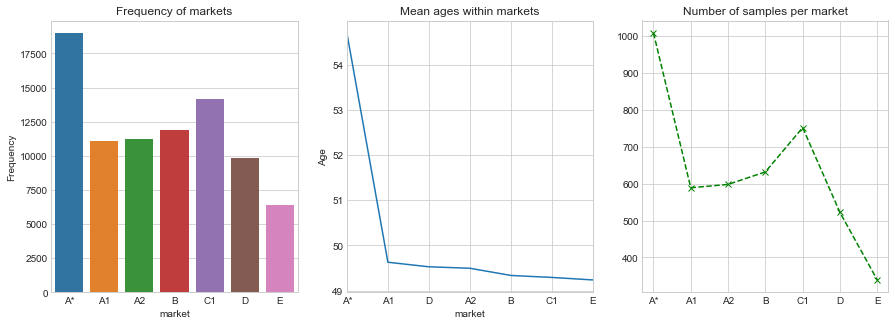

In [84]:
#Visualizations
fig, (axis1,axis2,axis3) = plt.subplots(1,3,figsize=(15,5))
df.sort_values('market',inplace=True)
sns.countplot(x='market', data=df,ax=axis1)
axis1.set_ylabel("Frequency")
axis1.set_title("Frequency of markets")
np.random.seed(3)
df['Age']=np.random.randint(20, 80, len(df))
marktA = df['market'] == 'A*'
df['Age'] = df.market.apply(lambda c: np.random.randint(30, 80) if c == 'A*' else np.random.randint(20, 80)) 
aa=df.groupby(df['market'])['Age'].mean().sort_values(ascending=False)
aa.plot(ax=axis2)
axis2.set_ylabel("Age")
axis2.set_title("Mean ages within markets")

def sample_num(x):
    return round((4440/83479)*x)

entries_per_mrkt=(18967,14133,11879,11251,11070,9810,6369)
li=[]
for i in entries_per_mrkt:
    li.append(sample_num(i))
keys=['A*','C1','B','A2','A1','D','E']    

di=dict(zip(keys, li))
lists = sorted(di.items()) # sorted by key, return a list of tuples

x, y = zip(*lists) # unpack a list of pairs into two tuples
plt.plot(x,y,"x",color='g',linestyle='dashed')
plt.title("Number of samples per market")